Part I: Define an RL Environment [30 pts]

In [6]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

Initial State


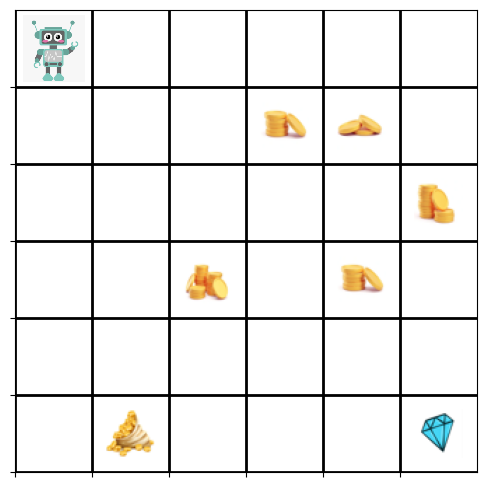

Running For 10 steps
State: (0, 0), Next State: (0, 0), Action: 0, Action Name: Up, Cumulative Reward: 0, Iteration: 1
No movement. Reward not updated.


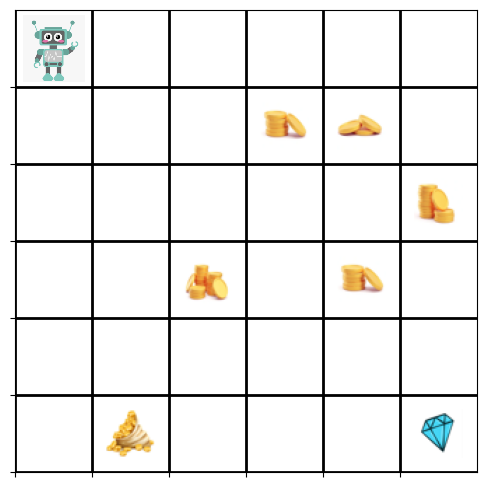

State: (0, 0), Next State: (1, 1), Action: 4, Action Name: Diagonal Down Right, Cumulative Reward: -1, Iteration: 2


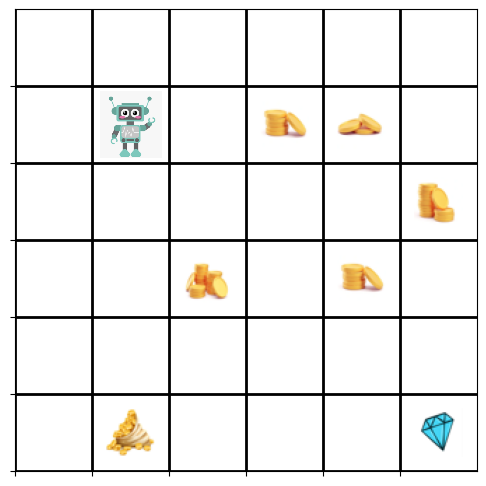

State: (1, 1), Next State: (2, 1), Action: 1, Action Name: Down, Cumulative Reward: -2, Iteration: 3


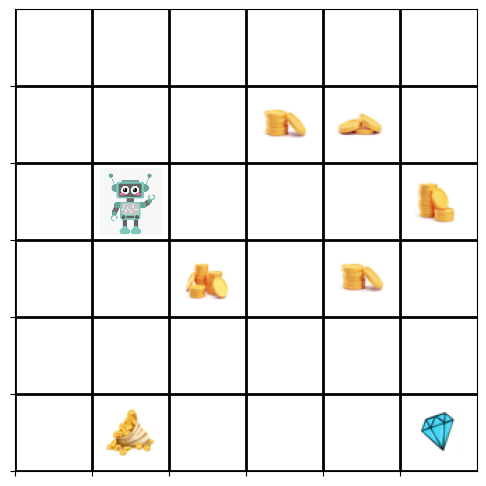

State: (2, 1), Next State: (2, 0), Action: 3, Action Name: Left, Cumulative Reward: -3, Iteration: 4


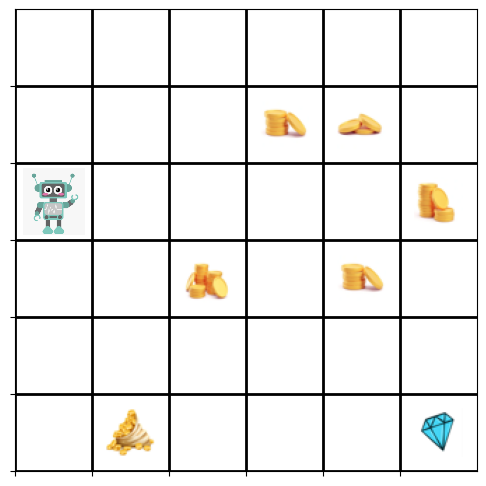

State: (2, 0), Next State: (2, 1), Action: 2, Action Name: Right, Cumulative Reward: -4, Iteration: 5


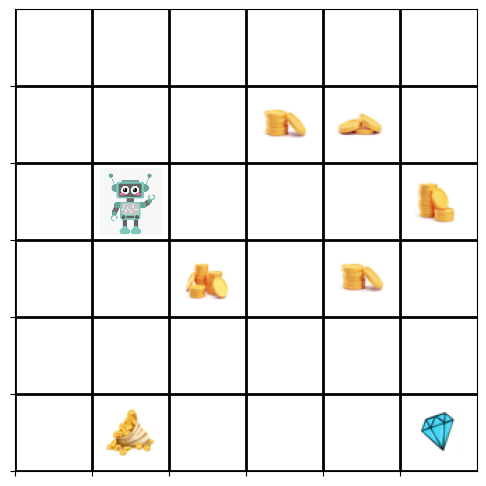

State: (2, 1), Next State: (3, 2), Action: 4, Action Name: Diagonal Down Right, Cumulative Reward: 16.0, Iteration: 6


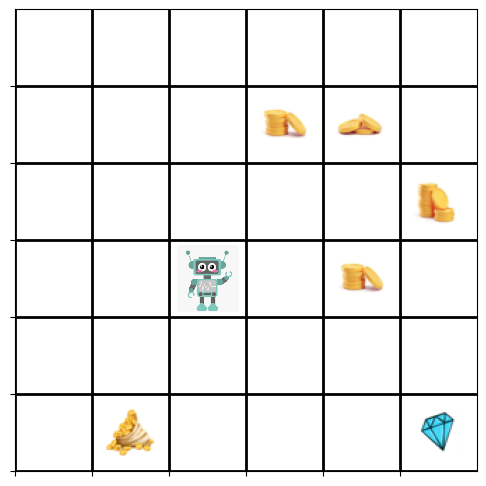

State: (3, 2), Next State: (4, 3), Action: 4, Action Name: Diagonal Down Right, Cumulative Reward: 15.0, Iteration: 7


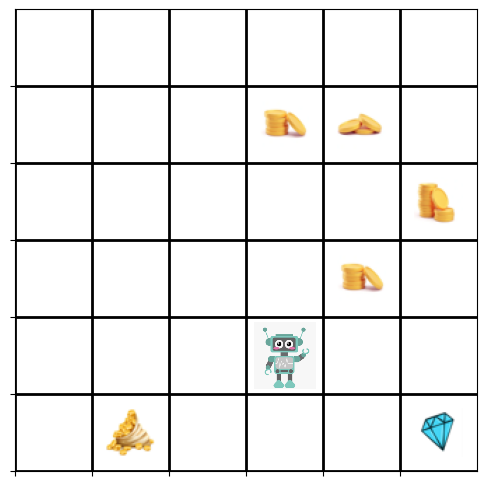

State: (4, 3), Next State: (5, 3), Action: 1, Action Name: Down, Cumulative Reward: 14.0, Iteration: 8


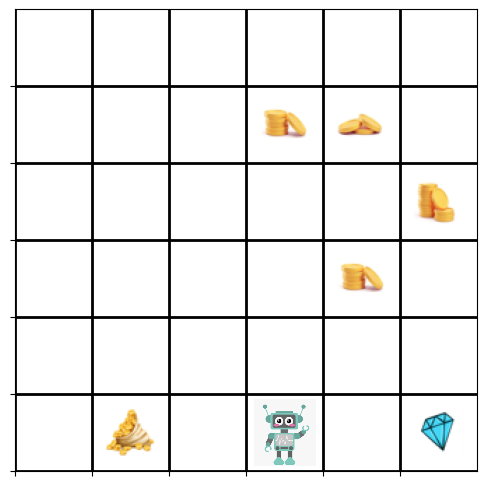

State: (5, 3), Next State: (4, 3), Action: 0, Action Name: Up, Cumulative Reward: 13.0, Iteration: 9


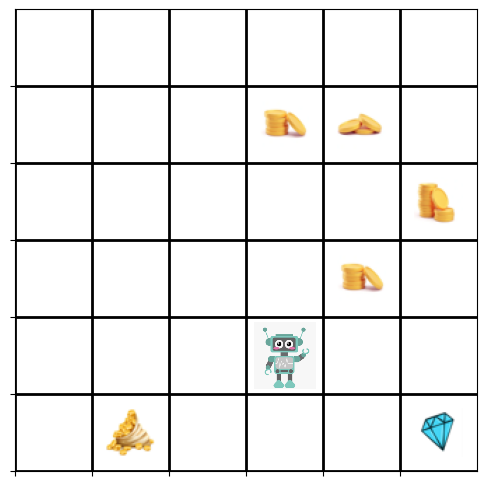

State: (4, 3), Next State: (5, 4), Action: 4, Action Name: Diagonal Down Right, Cumulative Reward: 12.0, Iteration: 10


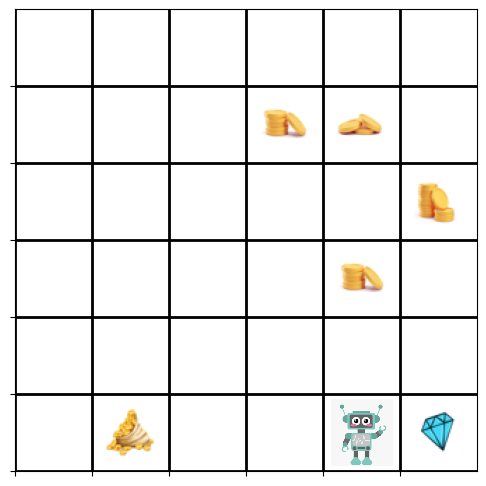

In [19]:

class GridWorld(gym.Env):
    def __init__(self):
        super().__init__()

        # Grid dimensions
        self.grid_size = 6
        self.state_space = self.grid_size * self.grid_size        

        # Action space
        self.action_space = spaces.Discrete(5)  # 0: Up, 1: Down, 2: Right, 3: Left, 4: Diagonal Down Right
        self.action_names = ["Up", "Down", "Right", "Left", "Diagonal Down Right"]

        # Observation space (6x6 grid positions) Flat index of (row, col)
        self.observation_space = spaces.Discrete(self.state_space)

        # Reward matrix
        self.rewards = np.zeros((self.grid_size, self.grid_size))
        self.rewards[1, 4] = 5 
        self.rewards[2, 5] = 15
        self.rewards[3, 4] = 10
        self.rewards[1, 3] = 10
        self.rewards[5, 1] = 25
        self.rewards[3, 2] = 20
        self.rewards[5, 5] = 100

        # Initial state
        self.state = (0, 0)
        # Initialize the total reward
        self.total_reward = 0

    def render(self):
        fig, ax = plt.subplots(figsize=(6, 6))

        # Create grid
        ax.set_xlim(0, self.grid_size)
        ax.set_ylim(0, self.grid_size)
        ax.set_xticks(np.arange(0, self.grid_size, 1))
        ax.set_yticks(np.arange(0, self.grid_size, 1))   
        ax.grid(True, which='both', color='black', linewidth=2)
        ax.set_xticklabels([]) 
        ax.set_yticklabels([]) 
        ax.set_aspect('equal')

        # Load reward images
        reward_images = {
            5: "images/reward5.png",
            10: "images/reward10.png",
            15: "images/reward15.png",
            20: "images/reward20.png",
            25: "images/reward25.png",
            100: "images/reward100.png",
        }

        # Image size
        image_size = 0.2
        image_width = 35
        image_height = 35

        # Plot rewards and agent
        for i in range(self.grid_size):
            for j in range(self.grid_size):
                reward = self.rewards[i, j]            
                if reward != 0:
                    reward_image = reward_images.get(reward)
                    if reward_image:
                        try:
                            img = Image.open(reward_image)
                            img = img.resize((image_width, image_height))
                            imagebox = OffsetImage(img)
                            ab = AnnotationBbox(imagebox, (j + 0.5, self.grid_size - 1 - i + 0.5), frameon=False, boxcoords="data")
                            ax.add_artist(ab)
                        except FileNotFoundError:
                            print(f"Warning: Image for reward {reward} not found.")
        agent_row, agent_col = self.state
        try:
            agent_img = Image.open("images/agent.png")
            agent_img = agent_img.convert("RGBA")
            agent_imagebox = OffsetImage(agent_img, zoom=image_size)
            agent_ab = AnnotationBbox(agent_imagebox, (agent_col + 0.5, self.grid_size - 1 - agent_row + 0.5), frameon=False, boxcoords="data")
            ax.add_artist(agent_ab)
        except FileNotFoundError:
            print("Warning: 'agent.png' image not found.")

        plt.show()

    def step(self, action):
        row, col = self.state
        old_state = self.state
        
        # Calculate new position based on action
        if action == 0:  # Up
            row = max(0, row - 1)
        elif action == 1:  # Down
            row = min(self.grid_size - 1, row + 1)
        elif action == 2:  # Right
            col = min(self.grid_size - 1, col + 1)
        elif action == 3:  # Left
            col = max(0, col - 1)
        elif action == 4:  # Diagonal Down Right
            if row < self.grid_size - 1 and col < self.grid_size - 1:
                row = row + 1
                col = col + 1

        self.state = (row, col)

        # If the state didn't change, no further processing for rewards.
        if self.state == old_state:
            return self.state, self.total_reward, False, False, {}

        # Get reward for the new position
        reward_collected = self.rewards[row, col]

        # If there's a reward, add it , after that make reward 0 for that cell
        if reward_collected != 0:
            self.total_reward += reward_collected
            self.rewards[row, col] = 0
        else:
            # Apply penalty if no reward at the new position
            self.total_reward -= 1
        
        # Check if the goal state is reached
        done = False
        if self.state == (5, 5):
            done = True  # Goal reached
        
        return self.state, self.total_reward, done, False, {}

    def reset(self):
        self.state = (0, 0)
        self.total_reward = 0
        return self.state


# Testing the environment
env = GridWorld()
state = env.reset()
print("Initial State")
env.render()
print("Running For 10 steps")
for iteration in range(10):
    action = env.action_space.sample()
    next_state, total_reward, done, _, _ = env.step(action)

    action_name = env.action_names[action]    
    print(f"State: {state}, Next State: {next_state}, Action: {action}, Action Name: {action_name}, Cumulative Reward: {total_reward}, Iteration: {iteration + 1}")
    if(state == next_state):
        print("No movement. Reward not updated.")
    env.render()
    
    state = next_state
    if done:
        print("Goal Achieved!")
        break
